# Charts

In [ ]:
import plotly
import plotly.graph_objs as go
from collections import deque
from datetime import datetime
import numpy as np
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px

In [ ]:
class Analytica:

    __current_price = 0.08 # minimum price for 1 kW of energy

    @staticmethod
    def increase_pattern(x):
        return x/2500

    @staticmethod
    def calculate(total_consumptions: list) -> int: # method to calculate current price
        final_price = Analytica.increase_pattern(np.sum(total_consumptions)/len(total_consumptions))

        Analytica.__current_price = final_price

        return final_price


    @staticmethod
    def get_current_price() -> int:
        return Analytica.__current_price

In [ ]:

import random as ran


def datagen(n,av):

    cl = []
    sum = av

    while len(cl) < n:
        sl = (av*0.1)/n
        r = ran.random()*2*sl-sl

        r = r*av
        if sum + r < av *10 and sum + r >= 0:
            sum += r
        
        cl.append(sum)

    return cl


In [ ]:
fig = make_subplots(rows=3, cols=3)

In [ ]:
users = []

for _ in range(10):

    users.append(datagen(5000,np.random.randint(40,80)))

In [ ]:
for i in range(3):
    for j in range(3):
        fig.add_trace(
            go.Scatter(x=[k for k in range(len(users[0]))], y=users[i*3+j]),
            row=i+1, col=j+1
        )
fig.update_layout(height=600, width=800, title_text="10 Users energy consumption during a time interval")
fig.show()
fig.write_image("img1.jpg")

In [ ]:
total_avg_prices = []
total_avg_consumption = []

for j in range(len(users[0])):
    sum = 0
    for i in range(len(users)):
        sum += users[i][j]/10

    total_avg_consumption.append(sum)
    total_avg_prices.append(np.log(sum)/50+0.01)

In [ ]:
fig = px.line(total_avg_prices,height=600, width=800, title="Dynamic energy cost for total users at each timestamp")
fig.write_image("img2.jpg")

In [ ]:
fig = make_subplots(rows=3, cols=3)

In [ ]:
users_new_prices = []

for i in range(len(users)):
    u = []
    for j in range(len(users[0])):
        coeff = users[i][j] / total_avg_consumption[j]
        u.append(coeff*total_avg_prices[j])

    users_new_prices.append(u)

In [ ]:
for i in range(3):
    for j in range(3):
        fig.add_trace(
            go.Scatter(x=[k for k in range(len(users_new_prices[0]))], y=users_new_prices[i*3+j]),
            row=i+1, col=j+1
        )

fig.update_layout(height=600, width=800, title_text="10 Users energy cost per 1 kW")
fig.show()
fig.write_image("img3.jpg")

# Forecastig

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
    x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

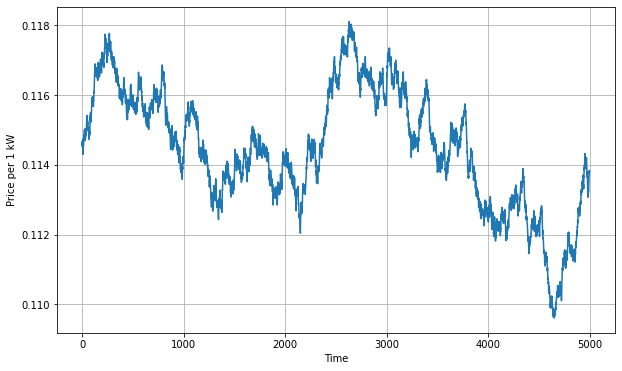

In [ ]:
time = np.arange(len(users_new_prices[0]), dtype="float32")

# Create the series
series = users_new_prices[1]

# Update with noise

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Price per 1 kW')

In [ ]:
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]



In [ ]:
window_size =32
batch_size = 16
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 3)

])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 32, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
186/186 [==============================] - 7s 10ms/step - loss: 0.0079 - lr: 1.0000e-08
Epoch 2/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0079 - lr: 1.1220e-08
Epoch 3/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0079 - lr: 1.2589e-08
Epoch 4/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0078 - lr: 1.4125e-08
Epoch 5/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0078 - lr: 1.5849e-08
Epoch 6/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0078 - lr: 1.7783e-08
Epoch 7/100
186/186 [==============================] - 2s 11ms/step - loss: 0.0078 - lr: 1.9953e-08
Epoch 8/100
186/186 [==============================] - 4s 19ms/step - loss: 0.0078 - lr: 2.2387e-08
Epoch 9/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0077 - lr: 2.5119e-08
Epoch 10/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0077 - lr: 2.8184e-08
Epoch 

(1e-08, 0.001, 9.99e-09, 0.0008921421890718796)

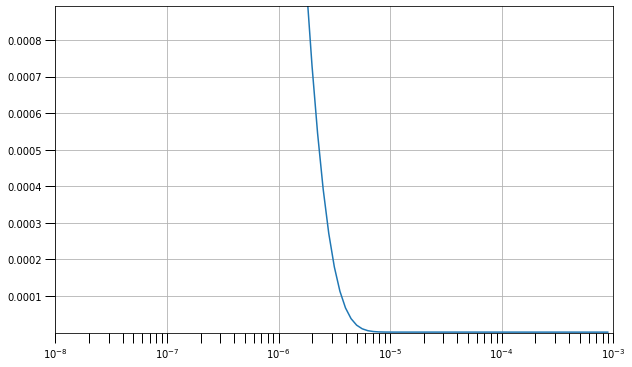

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, min(lrs)-min(lrs)/1000, max(lrs) + max(lrs)/1000])


In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
learning_rate = 0.00005

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=["mae"])

In [ ]:
history = model.fit(train_set,epochs=100)

Epoch 1/100
186/186 [==============================] - 4s 8ms/step - loss: 2.0072e-04 - mae: 0.0052
Epoch 2/100
186/186 [==============================] - 2s 8ms/step - loss: 9.8678e-07 - mae: 8.1873e-04
Epoch 3/100
186/186 [==============================] - 2s 8ms/step - loss: 9.7063e-07 - mae: 8.0966e-04
Epoch 4/100
186/186 [==============================] - 2s 8ms/step - loss: 9.4339e-07 - mae: 8.0031e-04
Epoch 5/100
186/186 [==============================] - 2s 8ms/step - loss: 9.5139e-07 - mae: 8.0125e-04
Epoch 6/100
186/186 [==============================] - 2s 8ms/step - loss: 8.8353e-07 - mae: 7.6377e-04
Epoch 7/100
186/186 [==============================] - 2s 8ms/step - loss: 8.3437e-07 - mae: 7.3529e-04
Epoch 8/100
186/186 [==============================] - 2s 8ms/step - loss: 7.6375e-07 - mae: 7.0814e-04
Epoch 9/100
186/186 [==============================] - 2s 8ms/step - loss: 7.3471e-07 - mae: 6.8791e-04
Epoch 10/100
186/186 [==============================] - 2s 8ms/step 

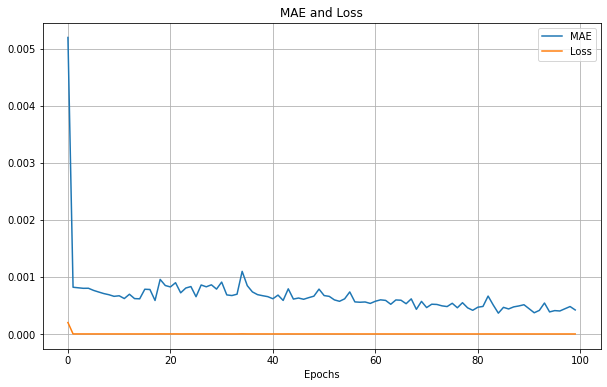

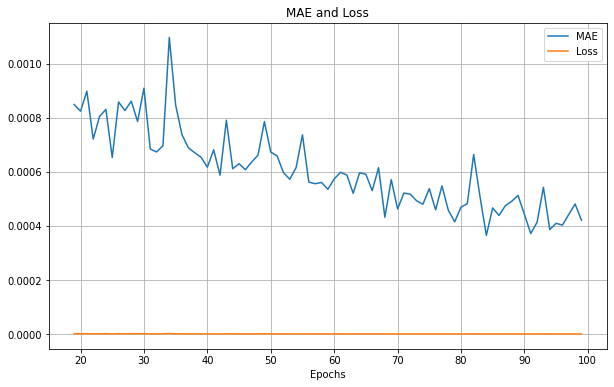

In [ ]:
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Scatter(x=time_valid, y=results),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=time_valid, y=x_valid),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Forecasted results")
fig.show()
fig.write_image("img8.jpg")

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4.1926548e-08
0.00016518822
